<a href="https://colab.research.google.com/github/ipulkitg/Coursera_Capstone/blob/main/Coursera_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Capstone Project - The Battle of the Neighborhoods (Week 2)**
###Applied Data Science Capstone by IBM/Coursera

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1.  <a href="#item1">Introduction</a>

2.  <a href="#item2">Data</a>

3.  <a href="#item3">Importing python libraries and dependencies</a>

4.  <a href="#item4">Data Extraction and Cleaning</a>

5.  <a href="#item5">Methodology</a>  

6.  <a href="#item5">Analysis</a>  

7.  <a href="#item5">Clustering</a>  

8.  <a href="#item5">Examine Clusters</a>  

9.  <a href="#item5">Results and Discussion</a>  

10.  <a href="#item5">Conclusion</a>  

    </font>
    </div>


## 1. Introduction


Varanasi is a city in the northern Indian state of Uttar Pradesh dating to the 11th century B.C. Regarded as the spiritual capital of India, the city draws Hindu pilgrims who bathe in the Ganges River’s sacred waters and perform funeral rites. Along the city's winding streets are some 2,000 temples, including Kashi Vishwanath, the “Golden Temple,” dedicated to the Hindu god Shiva. This results in a lot of tourists visiting this city.

The aim of the project is to identify venues in varanasi, India based on their rating and average prices. In this project, we will identify various venues in the city of varanasi, India, using Foursquare API and Zomato API, to help visitors select the restaurants that suit them the best.

Whenever a user is visiting a city they start looking for places to visit during their stay. They primarily look for places based on the venue ratings across all venues and the average prices such that the locations fits in their budget.

Here, we'll identify places that are fit for various individuals based on the information collected from the two APIs and Data Science. Once we have the plot with the venues, any company can launch an application using the same data and suggest users such information.

##2. Data


**Data Description:**

To begin with, we will take a look at varanasi on the Map using the folium library.

Then, we will fetch the data from two different APIs and then combine the following data into one single dataset.

**Foursquare API Data:**

We will need data about different venues in different neighborhoods of that specific borough. In order to gain that information we will use "Foursquare" locational information. Foursquare is a location data provider with information about all manner of venues and events within an area of interest. Such information includes venue names, locations, menus and even photos. As such, the foursquare location platform will be used as the sole data source since all the stated required information can be obtained through the API.

After finding the list of neighborhoods, we then connect to the Foursquare API to gather information about venues inside each and every neighborhood.

The data retrieved from Foursquare contained information of venues within a specified distance of the longitude and latitude.

**ZOMATO API Data:**

Zomato APIs give you access to the freshest and most exhaustive information for over 1.5 million restaurants across 10,000 cities globally. With the Zomato APIs, you can: Search for restaurants by name, cuisine, or location. Display detailed information including ratings, location and cuisine.

##3. Importing python libraries and dependencies

Before we get the data and start exploring it, let's download all the dependencies that we will need.


In [33]:
import pandas as pd # library for data analsysis
import requests
import numpy as np # library to handle data in a vectorized manner
!pip install geocoder
import geocoder
import folium
import requests 
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
import xml
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from pandas.io.json import json_normalize 
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim 
from bs4 import BeautifulSoup

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print("All Required Libraries Imported!")

All Required Libraries Imported!


## 4. Data Extraction and Cleaning


we will essentially need a dataset that contains the restaurants that exist in varanasi as well as the the latitude and logitude coordinates of the same


to avoid confusion, I initially took a location in varanasi and used geocoder for latitude and longitude.

In [34]:
address = '1 Cariapa Road, Varanasi, India'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
VRS_LATITUDE = location.latitude
VRS_LONGITUDE = location.longitude
print('The geograpical coordinate of Varanasi are {}, {}.'.format(VRS_LATITUDE, VRS_LONGITUDE))

The geograpical coordinate of Varanasi are 25.3206621, 82.9703638.


Dispplaying values

In [35]:
VRS_LATITUDE = 25.3176
VRS_LONGITUDE = 82.9739
print('The geograpical coordinates of Varanasi are {}, {}.'.format(VRS_LATITUDE, VRS_LONGITUDE))

The geograpical coordinates of Varanasi are 25.3176, 82.9739.


**MAP**

Let's use the folium library to create a complete map zoomed on varanasi. We'll also plot a marker on the coordinates we just identified above. This would give us a relatively good look at the center point we will be considering

In [36]:
varanasi_map = folium.Map(location = [VRS_LATITUDE, VRS_LONGITUDE], zoom_start = 13)
folium.Marker([VRS_LATITUDE, VRS_LONGITUDE]).add_to(varanasi_map)
varanasi_map

**Folium** is a great visualization library. Feel free to zoom into the above map, and click on each circle mark to reveal the name of the neighborhood and its respective borough.


**Define Foursquare Credentials and Version**


We begin by fetching a total of all venues in varanasi upto a range of 6 Kilometers using the Foursquare API. The Foursquare API has the explore API which allows us to find venue recommendations within a given radius from the given coordinates. We will use this API to find all the venues we need.

Enter foursquare credentials

In [37]:
FOURSQUARE_CLIENT_ID = 'JSAP2WGE2OFW5EPZ0E5Z15JOA5VZ30JXYXKZOR4VVGR21AOB' # your Foursquare ID
FOURSQUARE_CLIENT_SECRET = 'JFG0PS1YAKVWCWRMMERORF1AE34YIU3TEIJVT5W5V4G50LHD' # your Foursquare Secret
RADIUS = 6000 # 4 Km
NO_OF_VENUES = 100
VERSION = '20210118' # Current date
print('Your credentails have been loaded.')

Your credentails have been loaded.


define the get_category_type method to get the correct category for each venue.

In [38]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

We'll call the API over and over till we get all venues from the API within the given distance. The maximum venues this API can fetch is 47, so we will fetch all venues by iteratively calling this API and increasing the offset each time.

In [39]:
from pandas.io.json import json_normalize
import requests

pd.set_option('display.max_rows', None)

offset = 0
total_venues = 0
foursquare_venues = pd.DataFrame(columns = ['name', 'categories', 'lat', 'lng'])

while (True):
    url = ('https://api.foursquare.com/v2/venues/explore?client_id={}'
           '&client_secret={}&v={}&ll={},{}&radius={}&limit={}&offset={}').format(FOURSQUARE_CLIENT_ID, 
                                                                        FOURSQUARE_CLIENT_SECRET, 
                                                                        VERSION, 
                                                                        VRS_LATITUDE, 
                                                                        VRS_LONGITUDE,
                                                                        RADIUS,
                                                                        NO_OF_VENUES,
                                                                        offset)
    result = requests.get(url).json()
    venues_fetched = len(result['response']['groups'][0]['items'])
    total_venues = total_venues + venues_fetched
    print("Total {} venues fetched within a total radius of {} Km".format(venues_fetched, RADIUS/1000))

    venues = result['response']['groups'][0]['items']
    venues = json_normalize(venues)

    # Filter the columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
    venues = venues.loc[:, filtered_columns]

    # Filter the category for each row
    venues['venue.categories'] = venues.apply(get_category_type, axis = 1)

    # Clean all column names
    venues.columns = [col.split(".")[-1] for col in venues.columns]
    foursquare_venues = pd.concat([foursquare_venues, venues], axis = 0, sort = False)
    
    if (venues_fetched < 100):
        break
    else:
        offset = offset + 100

foursquare_venues = foursquare_venues.reset_index(drop = True)
print("\nTotal {} venues fetched".format(total_venues))

Total 40 venues fetched within a total radius of 6.0 Km

Total 40 venues fetched


**Zomato API**

The Zomato API allows using its search API to search for any given venue based on certain search filters such as query, latitude, longitude and more. Zomato also requires a Zomato user key which can be accessed with a developer account.

We'll use the name, lat, and lng values of various venues fetched from Foursquare API to use the search API and get more information regarding each venue.

In [40]:
headers = {'user-key': 'af8079a763f3bf08584e1d6ce0807f1b'}
venues_information = []

for index, row in foursquare_venues.iterrows():
    print("Fetching data for venue: {}".format(index + 1))
    venue = []
    url = ('https://developers.zomato.com/api/v2.1/search?q={}' + 
          '&start=0&count=1&lat={}&lon={}&sort=real_distance').format(row['name'], row['lat'], row['lng'])
    result = requests.get(url, headers = headers).json()
    if (len(result['restaurants']) > 0):
        venue.append(result['restaurants'][0]['restaurant']['name'])
        venue.append(result['restaurants'][0]['restaurant']['location']['latitude'])
        venue.append(result['restaurants'][0]['restaurant']['location']['longitude'])
        venue.append(result['restaurants'][0]['restaurant']['average_cost_for_two'])
        venue.append(result['restaurants'][0]['restaurant']['price_range'])
        venue.append(result['restaurants'][0]['restaurant']['user_rating']['aggregate_rating'])
        venue.append(result['restaurants'][0]['restaurant']['location']['address'])
        venues_information.append(venue)
    else:
        venues_information.append(np.zeros(6))
    
zomato_venues = pd.DataFrame(venues_information, 
                                  columns = ['venue', 'latitude', 
                                             'longitude', 'price_for_two', 
                                             'price_range', 'rating', 'address'])

Fetching data for venue: 1
Fetching data for venue: 2
Fetching data for venue: 3
Fetching data for venue: 4
Fetching data for venue: 5
Fetching data for venue: 6
Fetching data for venue: 7
Fetching data for venue: 8
Fetching data for venue: 9
Fetching data for venue: 10
Fetching data for venue: 11
Fetching data for venue: 12
Fetching data for venue: 13
Fetching data for venue: 14
Fetching data for venue: 15
Fetching data for venue: 16
Fetching data for venue: 17
Fetching data for venue: 18
Fetching data for venue: 19
Fetching data for venue: 20
Fetching data for venue: 21
Fetching data for venue: 22
Fetching data for venue: 23
Fetching data for venue: 24
Fetching data for venue: 25
Fetching data for venue: 26
Fetching data for venue: 27
Fetching data for venue: 28
Fetching data for venue: 29
Fetching data for venue: 30
Fetching data for venue: 31
Fetching data for venue: 32
Fetching data for venue: 33
Fetching data for venue: 34
Fetching data for venue: 35
Fetching data for venue: 36
F

In [41]:
zomato_venues

,venue,latitude,longitude,price_for_two,price_range,rating,address
0,Hotel Dolphin International,25.2995300290,82.9995642040,500.0,3.0,3.8,"B 20/48, Near Jain Mandir, Bhelupur, Varanasi"
1,Roof Top Restaurant,25.3091339738,83.0119670928,900.0,3.0,0,"D-3/24, Ganpati Guest House, Meer Ghat, Godaul..."
2,Kashi Chat Bhandar,25.3093479583,83.0059981719,150.0,1.0,4.5,"D-37/49, Godaulia, Varanasi"
3,0,0,0,0.0,0.0,0,None
4,Dawat,25.3093049190,83.0065517128,1200.0,4.0,3.3,"Hotel Ganges Grand, Godowlia Crossing, Godauli..."
5,Baba Lassi,25.3052458158,83.0083548278,200.0,1.0,3.1,"D-21/27, Rama Mahal, Munshi Ghat, Dashaswmedh ..."
6,The Siwon Lassi Shop,25.3114830000,83.0111220000,100.0,1.0,3.8,"Tripura Bhairwi Road, Nepali Kapda, Dashaswmed..."
7,Ganga View Cafe & Restaurant,25.3045829252,83.0086317658,500.0,3.0,3.4,"D22/16, Floor 1, Hotel Sita, Chausatti Ghat, B..."
8,Chaudhary Fast Food,25.3071617222,83.0096731335,180.0,1.0,0,"D 50, Dashaswmedh Ghat, Near Dashaswmedh Road,..."
9,Sol Bar - Hotel Surya,25.3387057134,82.9798902199,1500.0,4.0,3.3,"Hotel Surya, 20/51, A-5, The Mall Road, Varuna..."


#### Map Plotting


We will first plot the Foursquare data on the map

In [42]:
varanasi_map = folium.Map(location = [VRS_LATITUDE, VRS_LONGITUDE], zoom_start = 13)

for name, latitude, longitude in zip(foursquare_venues['name'], foursquare_venues['lat'], foursquare_venues['lng']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5,
        popup = label,
        color = 'green',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html = False).add_to(varanasi_map)  

#chandigarh_map.save("maps/Venues by Foursquare.html")
varanasi_map

We will also plot the Zomato data on the map.


In [43]:
VRS_LATITUDE = 25.3176
VRS_LONGITUDE = 82.9739
varanasi_map = folium.Map(location = [VRS_LATITUDE, VRS_LONGITUDE], zoom_start = 13)

for venue, address, latitude, longitude in zip(zomato_venues['venue'], zomato_venues['address'], 
                                               zomato_venues['latitude'], zomato_venues['longitude']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [float(latitude),float(longitude)],
        radius = 5,
        popup = label,
        color = 'red',
        fill = True,
        fill_color = '#cc3535',
        fill_opacity = 0.7,
        parse_html = False).add_to(varanasi_map)  
varanasi_map

<a id='item2'></a>


####Combining the dataset

Rounding off lattitude and longitude values

In [44]:
foursquare_venues['lat'] = foursquare_venues['lat'].apply(lambda lat: round(float(lat), 4))
foursquare_venues['lng'] = foursquare_venues['lng'].apply(lambda lng: round(float(lng), 4))
zomato_venues['latitude'] = zomato_venues['latitude'].apply(lambda lat: round(float(lat), 4))
zomato_venues['longitude'] = zomato_venues['longitude'].apply(lambda lng: round(float(lng), 4))

In [45]:
dataset = pd.concat([foursquare_venues, zomato_venues], axis = 1)
dataset['lat_diff'] = dataset['latitude'] - dataset['lat']
dataset['lng_diff'] = dataset['longitude'] - dataset['lng']

In [46]:
selected_venues = dataset[(abs(dataset['lat_diff']) <= 0.0004) & (abs(dataset['lng_diff']) <= 0.0004)].reset_index(drop = True)
selected_venues

,name,categories,lat,lng,venue,latitude,longitude,price_for_two,price_range,rating,address,lat_diff,lng_diff
0,Stops Hostel Varanasi,Hostel,25.2995,82.9997,Hotel Dolphin International,25.2995,82.9996,500.0,3.0,3.8,"B 20/48, Near Jain Mandir, Bhelupur, Varanasi",0.0000,-0.0001
1,Ganpati Guest House,Bed & Breakfast,25.3091,83.0122,Roof Top Restaurant,25.3091,83.0120,900.0,3.0,0,"D-3/24, Ganpati Guest House, Meer Ghat, Godaul...",0.0000,-0.0002
2,Kashi Chat Bhandar,Indian Restaurant,25.3095,83.0061,Kashi Chat Bhandar,25.3093,83.0060,150.0,1.0,4.5,"D-37/49, Godaulia, Varanasi",-0.0002,-0.0001
3,Hotel Surya,Hotel,25.3388,82.9800,Sol Bar - Hotel Surya,25.3387,82.9799,1500.0,4.0,3.3,"Hotel Surya, 20/51, A-5, The Mall Road, Varuna...",-0.0001,-0.0001
4,Assi Ghat,Temple,25.2888,83.0062,Teekha Fast Food & Restaurant,25.2889,83.0061,350.0,2.0,3.9,"Assi Ghat Varanasi, Assi Ghat, Varanasi",0.0001,-0.0001
5,Ashish Cafe,Café,25.2897,83.0060,Pizzeria Vaatika Cafe,25.2894,83.0061,500.0,3.0,4.2,"B 1/178, Assi Ghat, Varanasi",-0.0003,0.0001
6,Pizzeria Vaatika Café,Pizza Place,25.2894,83.0062,Pizzeria Vaatika Cafe,25.2894,83.0061,500.0,3.0,4.2,"B 1/178, Assi Ghat, Varanasi",0.0000,-0.0001
7,JHV Mall,Shopping Mall,25.3357,82.9777,McDonald's,25.3357,82.9778,500.0,3.0,4.3,"JHV Mall, Mall Road, Nadesar, Varanasi",0.0000,0.0001
8,Open Hand Café & Shop,Coffee Shop,25.2880,83.0045,Open Hand Shop & Cafe,25.2880,83.0045,450.0,2.0,4.0,"B1/128-3, Dumraun Bagh Colony, Assi Ghat, Vara...",0.0000,0.0000
9,Kerala Cafe,Indian Restaurant,25.3000,83.0012,The Belgian Waffle Co.,25.2997,83.0011,300.0,2.0,4.3,"Beside Kerala Cafe, Bhelupura Chauraha\nVaranasi",-0.0003,-0.0001


In [47]:
selected_venues = selected_venues.reset_index(drop = True)

we'll now select the venue name from Zomato API. I'll also get the average price per person by dividing the column price_for_two by 2 and removing this column from the dataset along with other unnecessary columns.

In [48]:
selected_venues['average_price'] = selected_venues['price_for_two']/2
selected_venues = selected_venues.drop(columns = ['name', 'lat', 'lng', 'lat_diff', 'lng_diff', 'price_for_two'])

In [49]:
selected_venues = selected_venues[selected_venues['rating'] != 0.0]

Let's check the size of the resulting dataframe


In [50]:
print("Total venues available: {}".format(selected_venues.shape[0]))

Total venues available: 15


##5. Methodology


This project aims at identifying the venues in varanasi based on their rating and average costs. This would enable any visitor to identify the venues he/she wants to visit based on their rating and cost preference.

As a first step, we retrieved the data from two APIs (Foursquare and Zomato). We extract venue information from the center of varanasi, upto a distance of 6 Km. The latitude and longitude values are then used to fetch venue rating and price from Zomato.

Secondly, we then explored the data retrieved from the two APIs on the map and identified the top category types. The data from the two sources is carefully combined based on the name, latitude and longitude values from the two sources. The final dataset would include the rating and price values for each venue.

Next, we'll analyse the data that we created based on the ratings and price of each venue. We'll identify places where many venues are located so that any visitor can go to one place and enjoy the option to choose amongst many venue options. We'll also explore areas that are high rated and those that are low rated while also plotting the map of high and low priced venues. Lastly, we'll cluster the venues based on the available information of each venue. This will allow us to clearly identify which venues can be recommended and with what characteristics.

Finally, we'll discuss and conclude which venues to be explored based on visitor requirement of rating and cost.

## 6. Analyze Each Neighborhood


The complete dataset is now in its final form.

We will inspect these venues based on their rating. The rating of a venue are based on user reviews and belongs to a range from 1 to 5. We'll also analyse the venues based on their price per person as well as the price range.

**Categories**


We have various types of venues in the final dataset. We will take a look at the venues and check which are the majority venue categories in the list.

<BarContainer object of 8 artists>

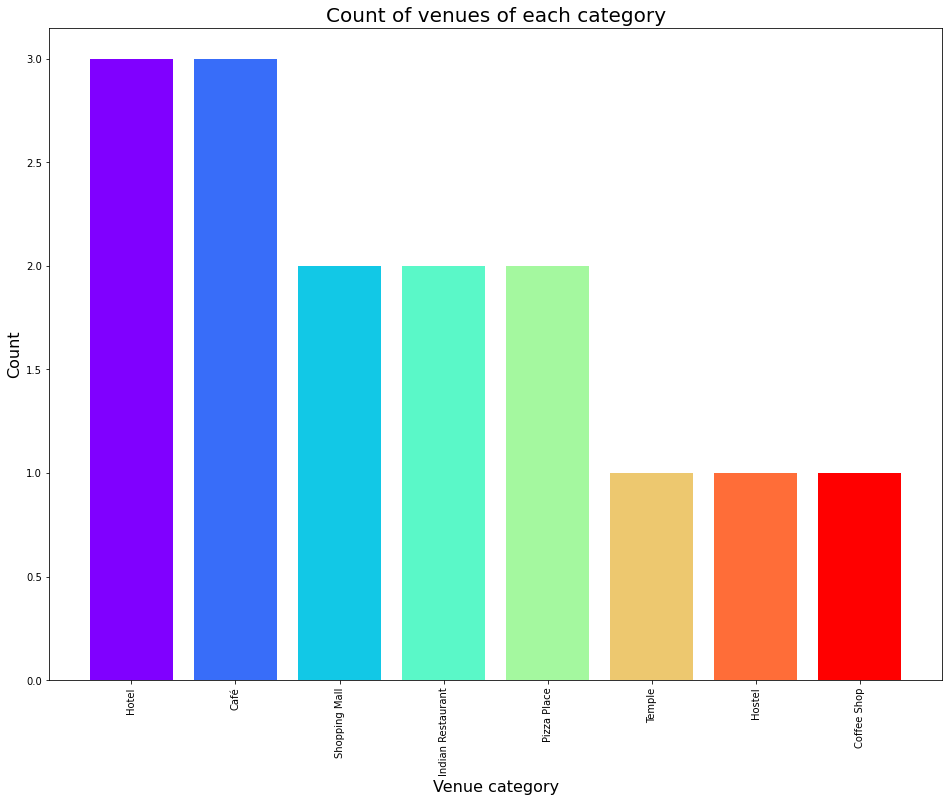

In [51]:
venue_distribution = selected_venues['categories'].value_counts()
colors = cm.rainbow(np.linspace(0, 1, len(venue_distribution.index)))
plt.figure(figsize = (16, 12))
plt.xticks(rotation = 90)
plt.xlabel("Venue category", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues of each category", fontsize = 20)
plt.bar(venue_distribution.index, venue_distribution.values, color = colors)

As we can see the majority venues are Hotel and Pizza Places. So suitale for tourists

**Rating**

Rating of a venue is an important factor on which a visitor decides whether it is worth it to visit the place. To cater to this, we will first see what is the average rating for all the venues in the city. Next, we will plot the venues on the map and color code them.

We'll first identify the various rating values and plot them as a bar plot with their counts to see the most common rating.

Text(0.5, 1.0, 'Count of venues with given rating')

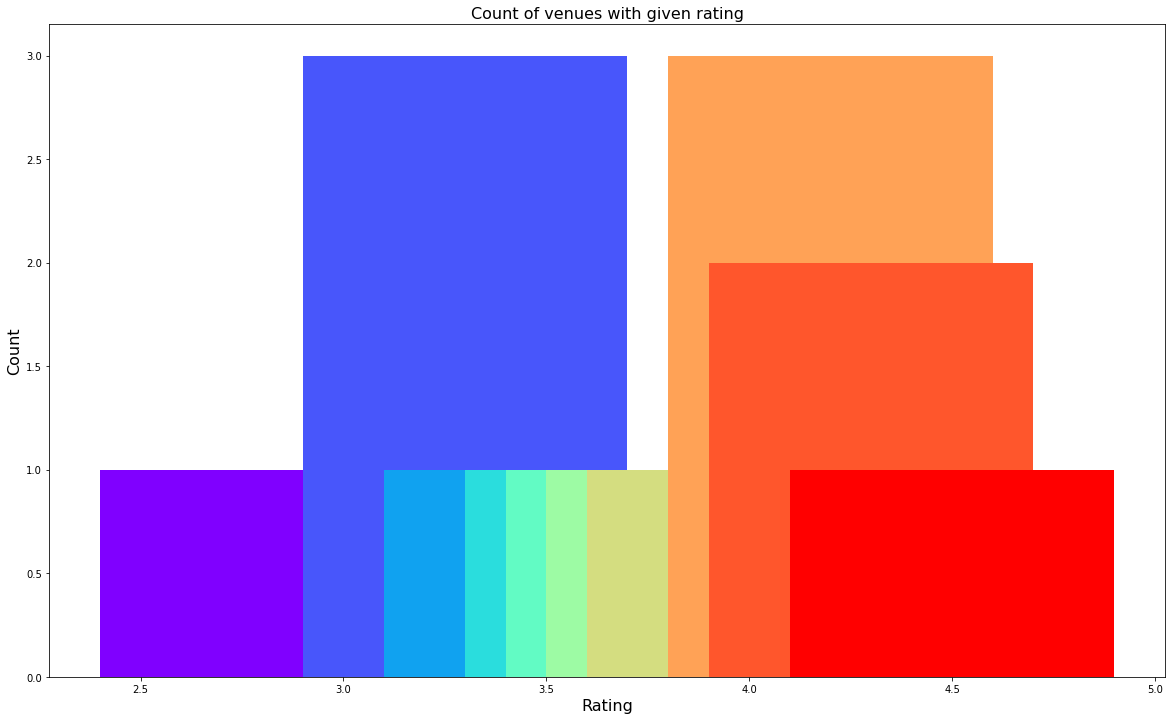

In [52]:
selected_venues['rating'] = selected_venues['rating'].astype(float)
rating = selected_venues['rating'].value_counts().sort_index()
plt.figure(figsize = (20, 12))
plt.bar(rating.index, rating.values, color = cm.rainbow(np.linspace(0, 1, len(rating.index))))
plt.xlabel("Rating", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.title("Count of venues with given rating", fontsize = 16)

From the plot above, it is clear that majority venues have their rating close to 3.5 and 4.

Let's create bins for various ratings and plot them in different colors on the map. The ratings will be divided between 4 bins:

1 to 2

2 to 3

3 to 4

4 to 5

In [53]:
bins = [1.0, 2.0, 3.0, 4.0, 5.0]
labels = ['Low', 'Okay', 'Good', 'Very good']
selected_venues['rating_bin'] = pd.cut(selected_venues['rating'].astype(float), bins = bins, labels = labels, include_lowest = True)

Now, we will plot the venues on the map.

In [54]:
color_map = {'Low': 'red', 'Okay': 'orange', 'Good': 'green', 'Very good': 'darkgreen'}

varanasi_map = folium.Map(location = [VRS_LATITUDE, VRS_LONGITUDE], zoom_start = 13)

for name, address, latitude, longitude, rating_bin in zip(selected_venues['venue'], 
                                                          selected_venues['address'], 
                                                          selected_venues['latitude'], 
                                                          selected_venues['longitude'], 
                                                          selected_venues['rating_bin']):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[rating_bin]),
        popup = label).add_to(varanasi_map)  
varanasi_map

Users might also be interested in going to a place that fits in their budget. I'll use the price_range column to plot the venues on a map. We'll represent the venues with lower price in green and move towards red as the price increases.

In [55]:
color_map = {'1.0': 'green', '2.0': 'darkgreen', '3.0': 'orange', '4.0': 'red'}

varanasi_map = folium.Map(location = [VRS_LATITUDE, VRS_LONGITUDE], zoom_start = 13)

for name, address, latitude, longitude, price_range in zip(selected_venues['venue'], 
                                                           selected_venues['address'], 
                                                           selected_venues['latitude'], 
                                                           selected_venues['longitude'], 
                                                           selected_venues['price_range'].astype(str)):
    label = '{}, {}'.format(name, address)
    label = folium.Popup(label, parse_html = True)
    folium.Marker(
        [latitude, longitude],
        icon = folium.Icon(color = color_map[price_range]),
        popup = label).add_to(varanasi_map)  
varanasi_map

## 7. Clustering


We will now cluster all these venues based on their price range, location and more to identify similar venues and the relationship amongst them. We'll cluster the venues into two separate groups.

In [56]:
from sklearn.cluster import KMeans

NO_OF_CLUSTERS = 3

clustering = selected_venues.drop(['venue', 'address', 'rating_bin', 'categories'], 1)
kMeans = KMeans(n_clusters = NO_OF_CLUSTERS, random_state = 0).fit(clustering)
selected_venues.insert(0, 'cluster_labels', kMeans.labels_)
selected_venues

,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,0,Hostel,Hotel Dolphin International,25.2995,82.9996,3.0,3.8,"B 20/48, Near Jain Mandir, Bhelupur, Varanasi",250.0,Good
2,2,Indian Restaurant,Kashi Chat Bhandar,25.3093,83.0060,1.0,4.5,"D-37/49, Godaulia, Varanasi",75.0,Very good
3,1,Hotel,Sol Bar - Hotel Surya,25.3387,82.9799,4.0,3.3,"Hotel Surya, 20/51, A-5, The Mall Road, Varuna...",750.0,Good
4,0,Temple,Teekha Fast Food & Restaurant,25.2889,83.0061,2.0,3.9,"Assi Ghat Varanasi, Assi Ghat, Varanasi",175.0,Good
5,0,Café,Pizzeria Vaatika Cafe,25.2894,83.0061,3.0,4.2,"B 1/178, Assi Ghat, Varanasi",250.0,Very good
6,0,Pizza Place,Pizzeria Vaatika Cafe,25.2894,83.0061,3.0,4.2,"B 1/178, Assi Ghat, Varanasi",250.0,Very good
7,0,Shopping Mall,McDonald's,25.3357,82.9778,3.0,4.3,"JHV Mall, Mall Road, Nadesar, Varanasi",250.0,Very good
8,0,Coffee Shop,Open Hand Shop & Cafe,25.2880,83.0045,2.0,4.0,"B1/128-3, Dumraun Bagh Colony, Assi Ghat, Vara...",225.0,Good
9,2,Indian Restaurant,The Belgian Waffle Co.,25.2997,83.0011,2.0,4.3,"Beside Kerala Cafe, Bhelupura Chauraha\nVaranasi",150.0,Very good
10,0,Pizza Place,Domino's Pizza,25.3161,82.9856,2.0,4.2,"14, Ground Floor, Cinema Site, IP Mallvaranasi...",200.0,Very good


Finally, let's visualize the resulting cluster

In [57]:
varanasi_map = folium.Map(location = [VRS_LATITUDE, VRS_LONGITUDE], zoom_start = 13)
color_map = { 0: 'green', 1: 'red',2:'blue',3:'orange'}

# add venues to the map
markers_colors = []
for venue, address, cluster, latitude, longitude in zip(selected_venues['venue'], 
                                                        selected_venues['address'], 
                                                        selected_venues['cluster_labels'], 
                                                        selected_venues['latitude'], 
                                                        selected_venues['longitude']):
    label = folium.Popup(str(venue) + ', ' + str(address), parse_html = True)
    folium.CircleMarker(
        [float(latitude), float(longitude)],
        radius = 5,
        popup = label,
        color = color_map[cluster],
        fill = True,
        fill_color = color_map[cluster],
        fill_opacity = 0.7).add_to(varanasi_map)

# add cluster centers to the map
for index, cluster in enumerate(kMeans.cluster_centers_):
    latitude = cluster[0]
    longitude = cluster[1]
    label = folium.Popup("Cluster: " + str(index), parse_html = True)
    folium.CircleMarker(
        [float(latitude), float(longitude)],
        radius = 10,
        popup = label,
        color = color_map[index],
        fill = True,
        fill_color = color_map[index],
        fill_opacity = 0.7).add_to(varanasi_map)

varanasi_map

## 8. Examine Clusters


Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.


#### Cluster 1

In [58]:
result = selected_venues[selected_venues['cluster_labels'] == 0]
print("Cluster 0")
result.head(10).reset_index(drop = True)

Cluster 0


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,0,Hostel,Hotel Dolphin International,25.2995,82.9996,3.0,3.8,"B 20/48, Near Jain Mandir, Bhelupur, Varanasi",250.0,Good
1,0,Temple,Teekha Fast Food & Restaurant,25.2889,83.0061,2.0,3.9,"Assi Ghat Varanasi, Assi Ghat, Varanasi",175.0,Good
2,0,Café,Pizzeria Vaatika Cafe,25.2894,83.0061,3.0,4.2,"B 1/178, Assi Ghat, Varanasi",250.0,Very good
3,0,Pizza Place,Pizzeria Vaatika Cafe,25.2894,83.0061,3.0,4.2,"B 1/178, Assi Ghat, Varanasi",250.0,Very good
4,0,Shopping Mall,McDonald's,25.3357,82.9778,3.0,4.3,"JHV Mall, Mall Road, Nadesar, Varanasi",250.0,Very good
5,0,Coffee Shop,Open Hand Shop & Cafe,25.2880,83.0045,2.0,4.0,"B1/128-3, Dumraun Bagh Colony, Assi Ghat, Vara...",225.0,Good
6,0,Pizza Place,Domino's Pizza,25.3161,82.9856,2.0,4.2,"14, Ground Floor, Cinema Site, IP Mallvaranasi...",200.0,Very good
7,0,Café,Shiva Cafe & German Bakery,25.3027,83.0072,3.0,3.3,"D 26/4, BHU Road, Himalaya Lodge, Dashaswmedh ...",300.0,Good
8,0,Hotel,Hotel The Westinn,25.3387,82.9804,3.0,3.7,"S20/52-2A-1 The Mall Road, Cantonment, Varuna ...",250.0,Good
9,0,Café,Brown Bread Bakery,25.3034,83.0072,3.0,3.3,"D 25/42 Ganga Mahal, Bangali Tola, Dashaswmedh...",250.0,Good


In [59]:
print("These venues for cluster 0 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 0 have mean price range of 2.73 and rating spread around 3.85


#### Cluster 2

In [60]:
result = selected_venues[selected_venues['cluster_labels'] == 1]
print("Cluster 1")
result.head(10).reset_index(drop = True)

Cluster 1


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,1,Hotel,Sol Bar - Hotel Surya,25.3387,82.9799,4.0,3.3,"Hotel Surya, 20/51, A-5, The Mall Road, Varuna...",750.0,Good


In [61]:
print("These venues for cluster 1 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 1 have mean price range of 4.00 and rating spread around 3.30


#### Cluster 3

In [62]:
result = selected_venues[selected_venues['cluster_labels'] == 2]
print("Cluster 2")
result.head(10).reset_index(drop = True)

Cluster 2


,cluster_labels,categories,venue,latitude,longitude,price_range,rating,address,average_price,rating_bin
0,2,Indian Restaurant,Kashi Chat Bhandar,25.3093,83.0060,1.0,4.5,"D-37/49, Godaulia, Varanasi",75.0,Very good
1,2,Indian Restaurant,The Belgian Waffle Co.,25.2997,83.0011,2.0,4.3,"Beside Kerala Cafe, Bhelupura Chauraha\nVaranasi",150.0,Very good
2,2,Shopping Mall,Amul Ice cream Parlour,25.3167,82.9902,1.0,2.8,"Ground Floor, I P Mall, Chetganj, Varanasi",50.0,Okay


In [63]:
print("These venues for cluster 2 have mean price range of {:.02f} and rating spread around {:.02f}".
      format(result['price_range'].mean(), result['rating'].astype(float).mean()))

These venues for cluster 2 have mean price range of 1.33 and rating spread around 3.87


## 9. Result and Discussion


Based on our analysis above, we can draw a number of conclusions that will be useful to aid any visitor visiting the city of varanasi, India.

After collecting data from the Foursquare and Zomato APIs, we got a list of 47 different venues. However, not all venues from the two APIs were identical. Hence, we had to inspect their latitude and longitude values as well as names to combine them and remove all the outliers. This resulted in a total venue count of 20.

We identified that from the total set of venues, majority of them were Hotel and Pizza Places.

Finally, through clusters we identified that there are many venues which are relatively lower priced but have an average rating of 3.57. On the other hand, there are few venues which are high priced and have average rating of 4.0.

A company can use this information to build up an online website/mobile application, to provide users with up to date information about various venues in the city based on the search criteria (name, rating and price).

## 10. Conclusion


The purpose of this project was to explore the places that a person visiting to varanasi . The venues have been identified using Foursquare and Zomato API and have been plotted on the map. The map reveals that there are so many places where one can visit during his stay in varanasi. Based on the visitor's venue rating and price requirements, he/she can choose the places.